In [ ]:
#| default_exp pipelines

In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports and setup

### Unconditional imports

In [ ]:
#| export

# print separately that we're loading dependencies, as this can take a while
# and we want to give immediate feedback the program is starting
from clip_plot.utils import timestamp
print(timestamp(), "Beginning to load dependencies")

2025-11-14 10:31:58.601339: Beginning to load dependencies


In [ ]:
#|export

from fastcore.all import in_ipython
from tqdm.auto import tqdm

from clip_plot.from_tables import cat_tables, table_to_meta
from clip_plot.web_config import copy_web_assets, get_clip_plot_root
from clip_plot.embeddings import get_embeddings, write_embeddings
from clip_plot.metadata import get_manifest, write_metadata
from clip_plot.images import create_atlases_and_thumbs, ImageFactory
from clip_plot.configuration import UmapSpec, ClusterSpec, ViewerOptions, ImageLoaderOptions, Cfg

In [ ]:
#| export

from shutil import rmtree
from pathlib import Path
import pandas as pd
import numpy as np


## Entry

`project_images` will kick off all the main functions for the module

In [ ]:
#| export

def project_images_pipeline(output_dir: Path,
                            plot_id: str,
                            model: str,
                            images: list[Path] | None,
                            viewer_opts: ViewerOptions,
                            umap_spec: UmapSpec,
                            cluster_spec: ClusterSpec,
                            image_opts: ImageLoaderOptions,
                            tables: list[Path] | None = None,
                            metadata: list[Path] | None = None,
                            image_path_col: str = "image_path",
                            vectors_path_col: str = "hidden_vectors_path",
        ):
        """Convert a folder of images into a clip-plot visualization"""

        if tables and images:
                raise ValueError("Provide either tables or images parameter, not both.")
        if not tables and not images:
                raise ValueError("No images found from either tables or images input.")
        if tables:
                print(timestamp(), "Loading tables")
                table = cat_tables(tables)
                images = list(table[image_path_col].values)
                print(timestamp(), "Loading embeddings from disk")
                hidden_vectors = np.array([np.load(e) for e in tqdm(table[vectors_path_col])])
        else:
                hidden_vectors = None
                table = None

        data_dir = output_dir / "data"
        imageEngine = ImageFactory(images, data_dir, metadata,
                                        **image_opts.model_dump(),)

        # grab metadata from table if provided
        if table is not None:
                imageEngine.meta_headers, imageEngine.metadata = table_to_meta(table)

        print(f"Config to project images: {str(image_opts.model_dump())}")

        np.random.seed(image_opts.seed)
        print(timestamp(), "Starting image processing pipeline.")

        copy_web_assets(output_dir=output_dir,
                        tagline=viewer_opts.tagline, logo=viewer_opts.logo)
        write_metadata(imageEngine)
        _, atlas_data = create_atlases_and_thumbs(imageEngine, plot_id)

        if hidden_vectors is None:
                hidden_vectors = get_embeddings(imageEngine, model_name=model)

        get_manifest(imageEngine, atlas_data, hidden_vectors,
                        plot_id=plot_id, output_dir=output_dir,
                        umap_spec=umap_spec, cluster_spec=cluster_spec
        )
        # write_images(imageEngine)
        print(timestamp(), "Done!")

### Embed images without building visualization

Outputs a table linking the embedding files to the images

Test with bash command:
```
clipplot_embed_images --images "tests/smithsonian_butterflies_10/jpgs/*.jpg" --output_dir "tests/smithsonian_butterflies_10/DELETEME_embed_only" --metadata "tests/smithsonian_butterflies_10/meta_data/good_meta.csv"
```

In [ ]:
#| export

def embed_images_pipeline(images: list[Path],
                     model: str,
                     metadata: list[Path] | None,
                     output_dir: Path,
                     table_format: str,
                     table_id: str,
                ):
                """Embed a folder of images, save embeddings as .npy file to disk"""
                output_dir = Path(output_dir)
                data_dir = output_dir / "data"

                imageEngine = ImageFactory(image_paths=images, data_dir=data_dir, metadata_paths=metadata)

                embeddings = get_embeddings(imageEngine, model_name=model)

                _model_shortname = "--".join(model.split("/")[-2:])

                embs_dir = data_dir/f"embeddings_{_model_shortname}"
                embs_dir.mkdir(parents=True, exist_ok=True)
                emb_paths = write_embeddings(embeddings, imageEngine.filenames, embs_dir)

                df = pd.DataFrame({"image_path": imageEngine.image_paths,
                                   "image_filename": imageEngine.filenames,
                                   "embed_path": [str(e) for e in emb_paths]})

                if len(imageEngine.metadata) > 0:
                        df_meta = pd.DataFrame(imageEngine.metadata)
                        df_meta = df_meta.rename(columns={"filename": "image_filename"})
                        # drop "image_path" column if df_meta has it
                        if "image_path" in df_meta.columns:
                                df_meta = df_meta.drop(columns=["image_path"])

                        df = df.merge(df_meta.drop_duplicates(["image_filename"]), on="image_filename")

                ## standardize sort order of table
                # put standard columns first if they exist in df
                standard_cols = pd.Index(["image_path", "image_filename", "embed_path", "category", "tags", "x", "y"])
                cols_sorted = standard_cols.intersection(df.columns)
                # append non-standard columns, sorted alphabetically
                cols_sorted = cols_sorted.append(df.columns.difference(standard_cols).sort_values())
                df = df[cols_sorted]
                for col in ["image_path", "embed_path"]:
                        df[col] = df[col].astype(str)

                if table_format == "csv":
                        df.to_csv(data_dir / f"EmbedImages__{table_id}.csv", index=False)
                else:
                        df.to_parquet(data_dir / f"EmbedImages__{table_id}.parquet", index=False)

In [ ]:
#| hide

def test_butterfly():
    copy_root_dir = get_clip_plot_root()
    tests_dir = copy_root_dir.parents[0] / "tests"

    test_images = tests_dir / "smithsonian_butterflies_10/jpgs/*.jpg"
    test_output_dir = tests_dir / "smithsonian_butterflies_10/output_test_temp"
    meta = tests_dir / "smithsonian_butterflies_10/meta_data/good_meta.csv"
    if Path(test_output_dir).exists():
        rmtree(test_output_dir)

    cfg = Cfg(paths={"images": test_images},)

    project_images_pipeline(images=cfg.paths.images,
                   output_dir=test_output_dir,
                   metadata=[meta],
                   plot_id="test_diff",
                   model=cfg.model,
                   viewer_opts = cfg.view_opts,
                   umap_spec = cfg.umap_spec,
                   cluster_spec = cfg.cluster_spec,
                   image_opts = cfg.image_opts,
                   )

    return

2025-11-14 10:31:59.376477: First three paths: /home/wsanger/git/clip-plot/tests/smithsonian_butterflies_10/jpgs/30aeb051d-ee0d-4c5b-8a85-a8da7baef5fd.jpg
/home/wsanger/git/clip-plot/tests/smithsonian_butterflies_10/jpgs/9fea3150-a3d4-11ed-aeea-e36f1256f233.jpg
/home/wsanger/git/clip-plot/tests/smithsonian_butterflies_10/jpgs/329a4c094-8536-4396-be70-3d9b5d0744d9.jpg
2025-11-14 10:31:59.376696: Validating input images


  0%|          | 0/12 [00:00<?, ?it/s]

Config to project images: {'seed': 42, 'shuffle': False, 'cell_size': 64, 'lod_cell_height': 128, 'atlas_size': 4096}
2025-11-14 10:31:59.626798: Starting image processing pipeline.
2025-11-14 10:31:59.680197: Copying images to output directory


  0%|          | 0/12 [00:00<?, ?it/s]

Device for inference: cpu


Device set to use cpu


2025-11-14 10:32:01.652298: Creating embeddings using timm/convnext_tiny.dinov3_lvd1689m


  0%|          | 0/12 [00:00<?, ?it/s]

2025-11-14 10:32:03.373986: Done creating embeddings.
2025-11-14 10:32:03.390087: Creating multi-umap layout
2025-11-14 10:32:03.435384: Creating {label} pointgrid
2025-11-14 10:32:03.457252: Creating grid layout
2025-11-14 10:32:03.458482: Creating rasterfairy layout


/home/wsanger/git/clip-plot/.venv/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/wsanger/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:267: RuntimeWarning: invalid value encountered in divide
  density_top /= np.sum(density_top)
/home/wsanger/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:273: RuntimeWarning: invalid value encountered in divide
  density_right /= np.sum(density_right)
/home/wsanger/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:279: RuntimeWarning: invalid value encountered in divide
  density_bottom /= np.sum(density_bottom)
/home/wsanger/git/clip-plot/.venv/lib/python3.10/site-packages/rasterfairy/coonswarp.py:285: RuntimeWarning: invalid value encountered in divide
  density_left /= np.sum(density_left)


2025-11-14 10:32:04.236434: Coonswarp rectification could not be performed data must be finite, check for nan or inf values
applying hungarian assignment for 12 indices
2025-11-14 10:32:04.239623: Creating categorical layout
2025-11-14 10:32:04.240686: Creating custom layout based on xy coordinates in metadata
2025-11-14 10:32:04.241916: Creating custom layout
2025-11-14 10:32:04.882181: Clustering data with HDBSCAN
2025-11-14 10:32:04.886107: Found 0 hotspots
2025-11-14 10:32:04.888138: Done!


/home/wsanger/git/clip-plot/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/wsanger/git/clip-plot/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


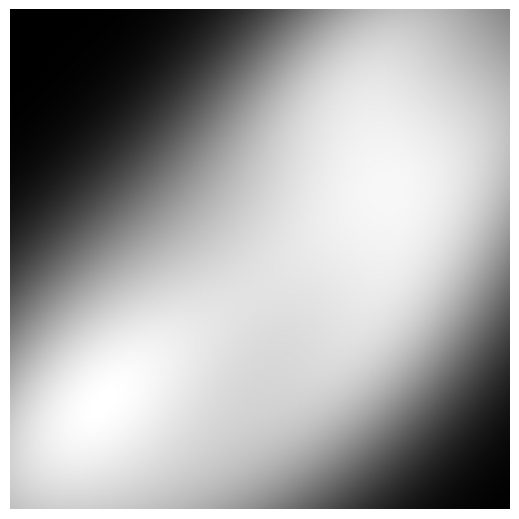

In [ ]:
#| hide

if __name__ == "__main__" and in_ipython():
    test_butterfly()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)